In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR #This is the autogression model we know from previous iteration
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Setting up Data Frames for the project!

In [106]:
df = pd.read_csv('../../csv/Combined_Data_Frame.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df = df.sort_values('Record Date')
df = df.interpolate()
df = df.drop(['Air Temperature(Apparent)', 'Cloud Coverage'], axis=1) 
df = df[1:]
df

,Total Demand,Wind Speed,Air Temperature
Record Date,,,
2018-01-02,61336.0,22.65,6.10
2018-01-03,62174.0,28.72,9.03
2018-01-04,62063.0,22.69,9.87
2018-01-05,61359.0,20.38,8.30
2018-01-06,58766.0,16.29,5.91
...,...,...,...
2021-12-27,57385.0,26.79,7.90
2021-12-28,56398.0,21.86,9.53
2021-12-29,54512.0,18.87,10.82


In [107]:
# A test that will be run later!
# train_set = df[(df['Record Date'] < '2021-01-01')]
# test_set = df[(df['Record Date'] >= '2021-01-01')]

### Auto corelation checking 

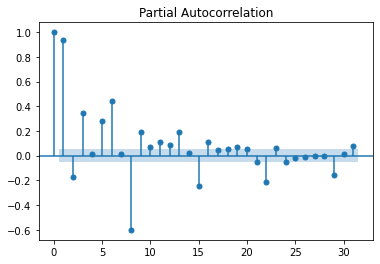

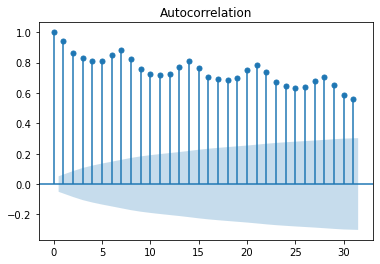

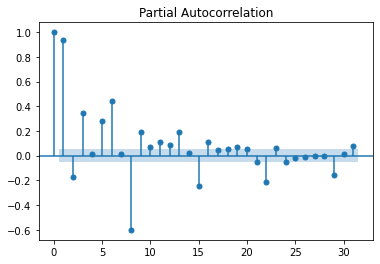

In [108]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

cr = df.copy()
cr = cr.drop(['Wind Speed', 'Air Temperature'], axis=1)


plot_acf(cr, lags=31)
plot_pacf(cr, lags=31)

In [109]:
period = 29

### Original Model

/Users/daniilsaleksasins/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

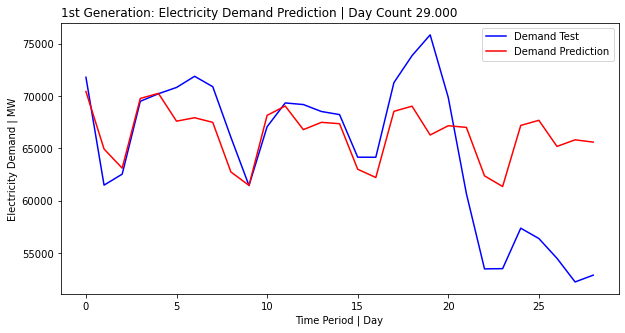

MAE: 4454.648
RMSE: 6068.713


In [110]:
X = cr.values #I'm using the second example data here (airline passengers)
train, test = X[1:len(X)-period], X[len(X)-period:] #we predict for ony 30 days for example

# train autoregression
model = AR(train)
model_fit = model.fit()

# print('Lag: %s' % model_fit.k_ar) #here we can access the perfect lag to use when we want to finetune other versions of our model
# print('Coefficients: %s' % model_fit.params) #here we access the coefficients computed per lag (shift of our time window)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# plot results
plt.figure(figsize=(10, 5))
plt.title("1st Generation: Electricity Demand Prediction | Day Count %.3f" % period, loc = 'left')

plt.plot(test, color='blue', label='Demand Test')
plt.plot(predictions, color='red', label = 'Demand Prediction')

plt.ylabel("Electricity Demand | MW")
plt.xlabel("Time Period | Day")

plt.legend()
plt.show()

mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)

rmse = mean_squared_error(test, predictions, squared=False)
print('RMSE: %.3f' % rmse)

### Creating model with lags

/Users/daniilsaleksasins/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


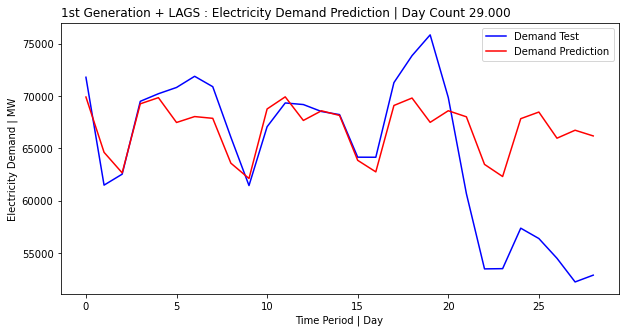

MAE: 4427.145
RMSE: 6317.652


In [111]:
from statsmodels.tsa.ar_model import ar_select_order #we can use this function to select the lags with the most autocorrelation
from statsmodels.tsa.ar_model import AutoReg #The AutoReg(ression) model is the updated version of the AR model. The mathematical concept is the same, there's just more parameters we can finetune to make the model fit our data better.

lags = ar_select_order(train, maxlag=31, seasonal=True, period=12)
# print(lags.ar_lags)

auto = AutoReg(train, lags=lags.ar_lags, trend="ct", seasonal=True, period=12).fit() #use the lag data we've selected as the ideal lags above, trend indicates whether to look at the trend too or only the constant values (or both)
predictions = auto.predict(start=len(train), end=len(train)+len(test)-1)
# for i in range(len(predictions)):
#     print('predicted=%f, actual=%f' % (predictions[i], test[i]))
    

plt.figure(figsize=(10, 5))
plt.title("1st Generation + LAGS : Electricity Demand Prediction | Day Count %.3f" % period, loc = 'left')

plt.plot(test, color='blue', label='Demand Test')
plt.plot(predictions, color='red', label = 'Demand Prediction')

plt.ylabel("Electricity Demand | MW")
plt.xlabel("Time Period | Day")

plt.legend()
plt.show()


mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)
rmse = mean_squared_error(test, predictions, squared=False)
print('RMSE: %.3f' % rmse)

### 3rd Generation AR model with the EXO variables

In [112]:
df2 = pd.read_csv('../../csv/Combined_Data_Frame.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df2 = df2.sort_values('Record Date')
df2 = df2.interpolate() 
df2 = df2[1:]
df2

,Total Demand,Wind Speed,Air Temperature(Apparent),Air Temperature,Cloud Coverage
Record Date,,,,,
2018-01-02,61336.0,22.65,15.35,6.10,78.58
2018-01-03,62174.0,28.72,20.15,9.03,93.00
2018-01-04,62063.0,22.69,19.00,9.87,92.93
2018-01-05,61359.0,20.38,18.35,8.30,84.29
2018-01-06,58766.0,16.29,15.82,5.91,89.51
...,...,...,...,...,...
2021-12-27,57385.0,26.79,16.47,7.90,90.19
2021-12-28,56398.0,21.86,16.37,9.53,93.61
2021-12-29,54512.0,18.87,20.07,10.82,97.43


In [113]:
X = df2['Total Demand'].values 
train, test = X[1:len(X)-period], X[len(X)-period:]

w = df2['Wind Speed'].values
w_train, w_test = w[1:len(w)-period], w[len(w)-period:]

a = df2['Air Temperature'].values
a_train, a_test = a[1:len(a)-period], a[len(a)-period:] 

ap = df2['Air Temperature(Apparent)'].values
ap_train, ap_test = ap[1:len(ap)-period], ap[len(ap)-period:] 

c = df2['Cloud Coverage'].values
c_train, c_test = c[1:len(c)-period], c[len(c)-period:] 

array_train = np.array([a_train, w_train, ap_train, c_train])
array_test = np.array([a_test, w_test, ap_test, c_test])

array_train = array_train.reshape((1429, 4)) 
array_test = array_test.reshape((period, 4))

### Checking if everything works before adding the EXO

/Users/daniilsaleksasins/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

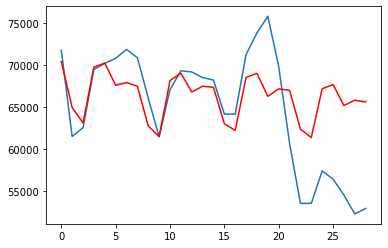

Test RMSE: 6068.713
MAE: 4454.648


In [114]:
from statsmodels.tsa.ar_model import AR

# train 
model = AR(train)
model_fit = model.fit()

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, actual=%f' % (predictions[i], test[i]))

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

rmse = mean_squared_error(test, predictions, squared=False)
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)

### EXO Model

In [115]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order

lags = ar_select_order(train, maxlag=30, seasonal=False, period=12)

auto = AutoReg(train, lags=lags.ar_lags, trend="t", seasonal=True, exog=array_train, period=12).fit()
predictions = auto.predict(start=len(train), end=len(train)+len(test)-1, exog_oos=array_test)


/Users/daniilsaleksasins/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


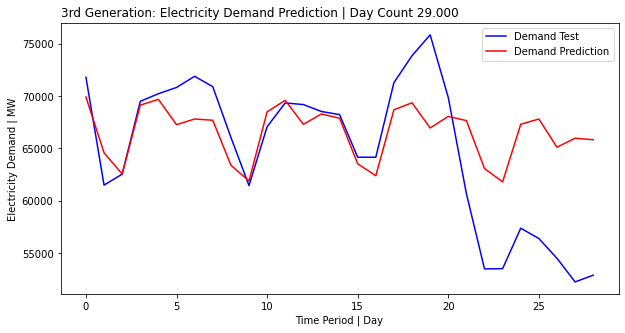

MAE: 4395.643
RMSE: 6110.950


In [116]:
plt.figure(figsize=(10, 5))
plt.title("3rd Generation: Electricity Demand Prediction | Day Count %.3f" % period, loc = 'left')

plt.plot(test, color='blue', label='Demand Test')
plt.plot(predictions, color='red', label = 'Demand Prediction')


plt.ylabel("Electricity Demand | MW")
plt.xlabel("Time Period | Day")

plt.legend()
plt.show()

mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)

rmse = mean_squared_error(test, predictions, squared=False)
print('RMSE: %.3f' % rmse)